<a href="https://www.kaggle.com/code/janstylewis7/lowlightanimalpytorch?scriptVersionId=231879854" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  IMPORTING LIBRARY

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device available:",device)
      

device available: cuda


# CREATING PATH AND LABEL

In [2]:
image_path = []
labels = []

dataset_dir = "/kaggle/input/low-light-animals/animals_low_light/animals_low_light/"

for label in os.listdir(dataset_dir):  
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):  
        for image in os.listdir(label_dir):  
            image_path.append(os.path.join(label_dir, image))
            labels.append(label)

data_df = pd.DataFrame({"image_paths": image_path, "labels": labels})

print(data_df.head())


                                         image_paths  labels
0  /kaggle/input/low-light-animals/animals_low_li...  beetle
1  /kaggle/input/low-light-animals/animals_low_li...  beetle
2  /kaggle/input/low-light-animals/animals_low_li...  beetle
3  /kaggle/input/low-light-animals/animals_low_li...  beetle
4  /kaggle/input/low-light-animals/animals_low_li...  beetle


In [3]:
print(data_df["labels"].unique())

['beetle' 'parrot' 'fox' 'wolf' 'hedgehog' 'turtle' 'snake' 'shark'
 'horse' 'antelope' 'hamster' 'woodpecker' 'eagle' 'chimpanzee' 'bison'
 'penguin' 'butterfly' 'sandpiper' 'hornbill' 'lion' 'lobster' 'oyster'
 'otter' 'grasshopper' 'raccoon' 'dog' 'pigeon' 'donkey' 'hippopotamus'
 'hummingbird' 'bear' 'coyote' 'bee' 'pig' 'rat' 'owl' 'caterpillar'
 'koala' 'squid' 'hare' 'whale' 'mouse' 'tiger' 'fly' 'lizard' 'orangutan'
 'bat' 'porcupine' 'kangaroo' 'gorilla' 'starfish' 'mosquito' 'crow'
 'possum' 'goldfish' 'swan' 'elephant' 'sheep' 'dragonfly' 'zebra' 'seal'
 'octopus' 'cow' 'ox' 'wombat' 'reindeer' 'panda' 'duck' 'goose' 'goat'
 'badger' 'flamingo' 'crab' 'seahorse' 'rhinoceros' 'dolphin' 'okapi'
 'moth' 'sparrow' 'pelecaniformes' 'squirrel' 'leopard' 'jellyfish'
 'ladybugs' 'cockroach' 'hyena' 'cat' 'deer' 'turkey' 'boar']


# SAMPLING TRAIN VAL TEST 

In [4]:
train=data_df.sample(frac=0.8,random_state=7) 
test=data_df.drop(train.index) 

val=test.sample(frac=0.5,random_state=7)
test=test.drop(val.index)

# LABEL ENCODER FOR ENCODING LABEL AND TRANFORMS FOR IMAGE CHANGE, CHANGES APPLIED AT __GETITEM__

In [5]:
label_encoder = LabelEncoder() 
label_encoder.fit(data_df['labels'])

transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ColorJitter(brightness=0.5, contrast=0.5),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

# 3 DIFFERENT TECHNIQUES FOR ENHANCING IMAGE BUT USED ONE BECAUSE OF TIME CONSUMPTION IN CPU

In [6]:
import cv2
import numpy as np

def enhance_image_clahe(image):
    """Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance the image."""
    if not isinstance(image, np.ndarray):
        raise ValueError(f"Expected a NumPy array, but got {type(image)}")
    
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged_lab = cv2.merge((cl, a, b))
    enhanced_image = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2BGR)
    return enhanced_image

def gamma_correction(image, gamma=1.5):
    """Adjust the brightness using gamma correction."""
    if not isinstance(image, np.ndarray):
        raise ValueError(f"Expected a NumPy array, but got {type(image)}")

    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    
    image = np.clip(image, 0, 255).astype(np.uint8)
    
    return cv2.LUT(image, table)

def denoise_image(image):
    """Apply Non-Local Means Denoising for color images."""
    if not isinstance(image, np.ndarray):
        raise ValueError(f"Expected a NumPy array, but got {type(image)}")

    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)




# TO GET AND APPLY ON DATASET PYTORCH FRAMEWORK

In [7]:
class LowLightAnimalDataset(Dataset):
    def __init__(self, df, transform=None, apply_enhancements=False):
        self.image_paths = df['image_paths'].values
        self.labels = df['labels'].values
        self.transform = transform
        self.apply_enhancements = apply_enhancements

    def __getitem__(self, idx):
       image_path = self.image_paths[idx]

       if not isinstance(image_path, str):
            raise ValueError(f"Invalid image path at index {idx}: {image_path}")

       image = cv2.imread(image_path)

       if image is None:
           raise FileNotFoundError(f"Image not found at path: {image_path}")

       if self.apply_enhancements:
           image = gamma_correction(image, gamma=0.6)  

       image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

       if self.transform:
           image = self.transform(image)

       label = torch.tensor(label_encoder.transform([self.labels[idx]])[0], dtype=torch.long)

       return image, label

    def __len__(self):
        return len(self.image_paths)



# APPLYING

In [8]:
train_dataset = LowLightAnimalDataset(train, transform=transform, apply_enhancements=True)
val_dataset = LowLightAnimalDataset(val, transform=transform, apply_enhancements=False)
test_dataset = LowLightAnimalDataset(test, transform=transform, apply_enhancements=False)

# IMAGES TO CHECK THE ENCHANCEMENT CHANGES

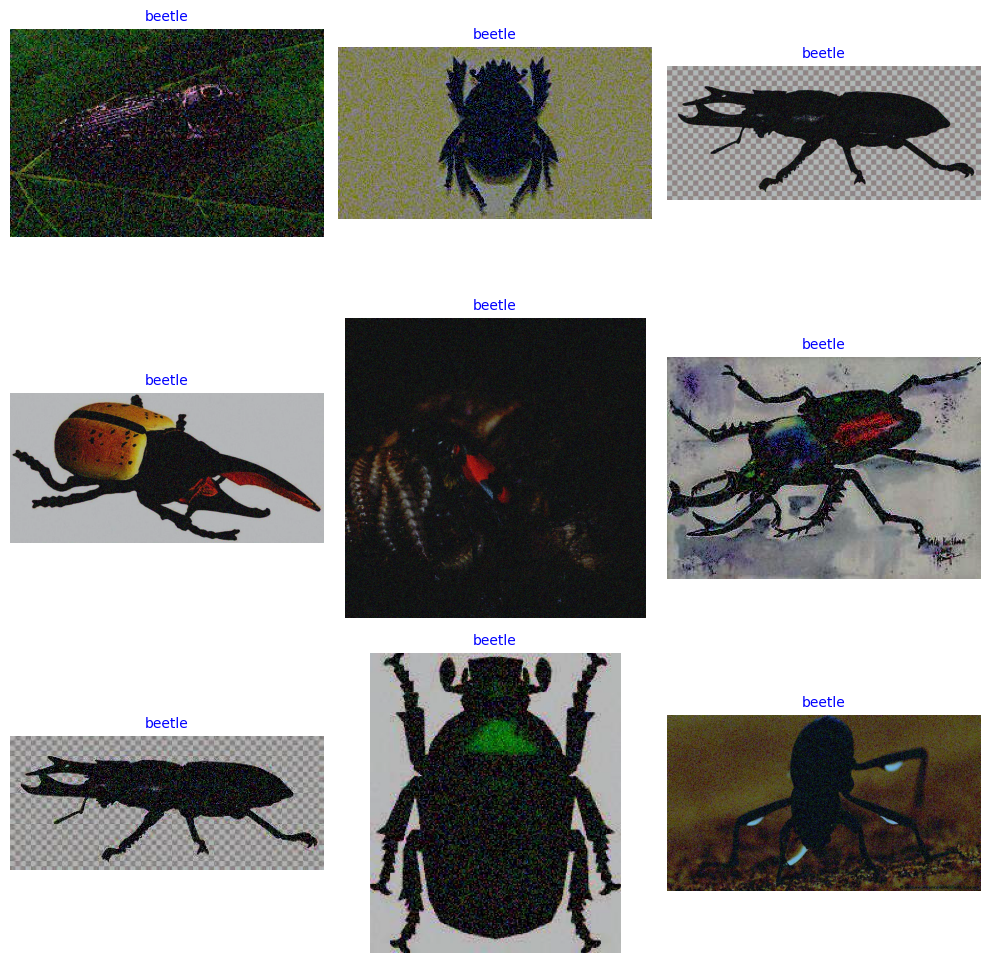

In [9]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image

specific_indices = [0, 2, 5, 10, 12, 20, 30, 35, 40]  
n_rows, n_cols = 3, 3  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

specific_samples = data_df.iloc[specific_indices].reset_index(drop=True)

for ax, (img_path, label) in zip(axes.flatten(), zip(specific_samples['image_paths'], specific_samples['labels'])):
    image = cv2.imread(img_path)  
    
    if image is None:
        continue  
    
    image = gamma_correction(image, gamma=0.6)  
    
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  
    
    ax.imshow(image)
    ax.axis("off") 
    ax.set_title(label, fontsize=10, color="blue")  

plt.tight_layout()
plt.show()



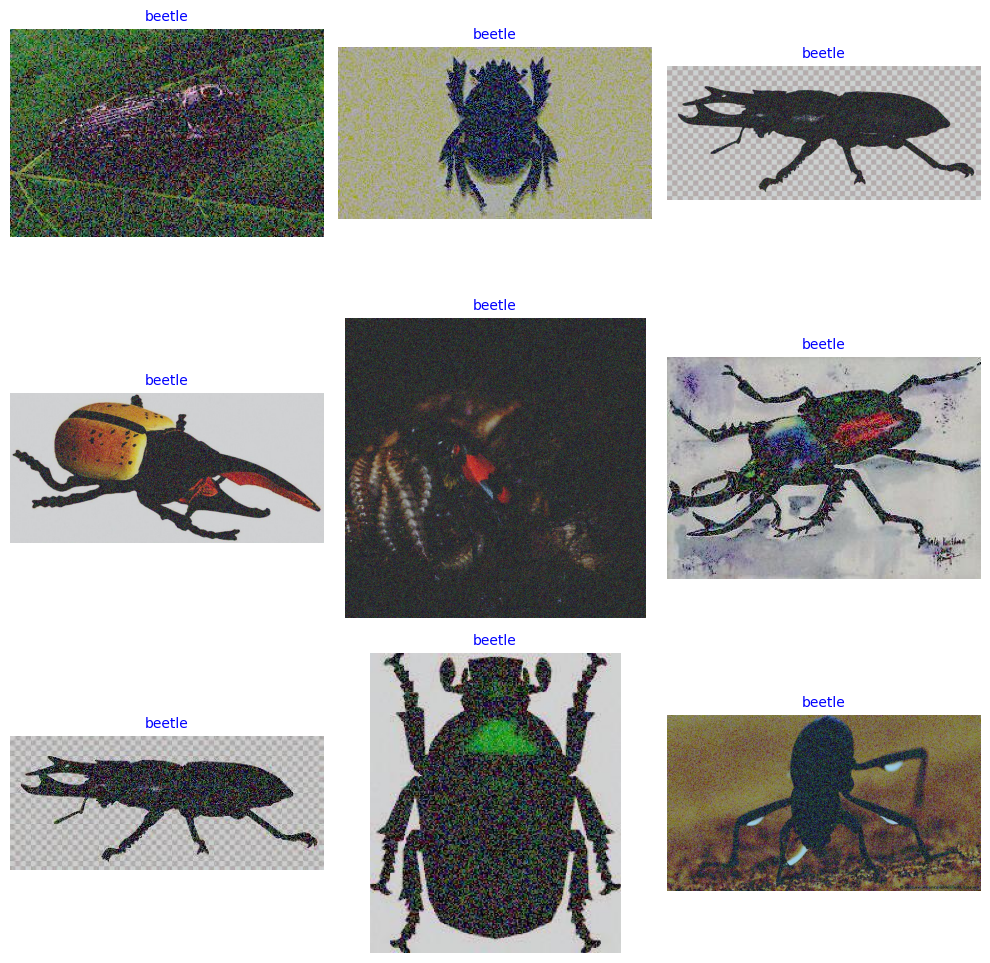

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

specific_indices = [0, 2, 5, 10, 12, 20, 30, 35, 40]  
n_rows, n_cols = 3, 3  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

specific_samples = data_df.iloc[specific_indices].reset_index(drop=True)

for ax, (img_path, label) in zip(axes.flatten(), zip(specific_samples['image_paths'], specific_samples['labels'])):
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis("off") 
    ax.set_title(label, fontsize=10, color="blue")  

plt.tight_layout()
plt.show()



In [11]:
BATCH_SIZE = 32
EPOCHS = 50

In [12]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0  
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0
)


In [13]:
torch.backends.cudnn.benchmark = True


# MODEL

In [14]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.GroupNorm(8, 32)  
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.GroupNorm(8, 64)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, 64)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.GroupNorm(8, 128)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.GroupNorm(8, 128)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, 128)
        )

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

num_classes = 90  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes).to(device)







In [15]:
!pip install torchsummary
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
         GroupNorm-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         GroupNorm-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]          36,928
              ReLU-8           [-1, 64, 32, 32]               0
         GroupNorm-9           [-1, 64, 32, 32]             128
           Conv2d-10          [-1, 128, 32, 32]          73,856
             ReLU-11          [-1, 128, 32, 32]               0
        GroupNorm-12          [-1, 128, 32, 32]             256
           Conv2d-13          [-1, 128, 16, 16]         147,584
             ReLU-14          [-1, 128,

# OPTIMIZER AND SCHEDULAR FOR LEARNING RATE

In [16]:
from torch.optim.lr_scheduler import CosineAnnealingLR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# SINCE CPU WAS BOTTLENECKING BECAUSE OF ENHANCEMENT WAS CHECKING USAGE 

In [17]:
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    record_shapes=True
) as prof:
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        break  # Just run one batch to profile

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...        71.86%     868.622ms        75.87%     917.064ms     917.064ms       0.000us         0.00%       0.000us       0.000us             1  
                                           aten::conv2d         0.00%      40.330us        23.19%     280.313ms      46.719ms       0.000us         0.00%     132.346ms      22.058ms             6  
         

In [18]:
print(torch.cuda.is_available())  
print(torch.cuda.device_count())  
print(torch.cuda.current_device())  
print(torch.cuda.get_device_name(0))  # Name of the GPU
print(torch.cuda.memory_allocated() / 1024**2, "MB allocated")  # Memory in MB


True
2
0
Tesla T4
123.837890625 MB allocated


# TRAINING 

In [19]:
import torch

total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0
    total_samples_train = 0
    total_samples_val = 0

    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) 

        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()

        total_loss_train += train_loss.item()
        total_acc_train += (torch.argmax(outputs, dim=1) == labels).sum().item()
        total_samples_train += labels.size(0)

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            total_loss_val += val_loss.item()
            total_acc_val += (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_samples_val += labels.size(0)

    avg_train_loss = total_loss_train / len(train_loader)
    avg_val_loss = total_loss_val / len(val_loader)

    train_accuracy = (total_acc_train / total_samples_train) * 100
    val_accuracy = (total_acc_val / total_samples_val) * 100

    scheduler.step()

    total_loss_train_plot.append(round(avg_train_loss, 4))
    total_loss_validation_plot.append(round(avg_val_loss, 4))
    total_acc_train_plot.append(round(train_accuracy, 4))
    total_acc_validation_plot.append(round(val_accuracy, 4))

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(avg_train_loss, 4)} Train Accuracy: {round(train_accuracy, 4)}%")
    print(f"Validation Loss: {round(avg_val_loss, 4)} Validation Accuracy: {round(val_accuracy, 4)}%")
    print("=" * 25)


Epoch 1/50, Train Loss: 4.4902 Train Accuracy: 2.037%
Validation Loss: 4.4788 Validation Accuracy: 1.4815%
Epoch 2/50, Train Loss: 4.3574 Train Accuracy: 3.3565%
Validation Loss: 4.3452 Validation Accuracy: 2.2222%
Epoch 3/50, Train Loss: 4.2774 Train Accuracy: 4.6296%
Validation Loss: 4.2572 Validation Accuracy: 3.5185%
Epoch 4/50, Train Loss: 4.1687 Train Accuracy: 5.4861%
Validation Loss: 4.2252 Validation Accuracy: 5.0%
Epoch 5/50, Train Loss: 4.0809 Train Accuracy: 7.2222%
Validation Loss: 4.1245 Validation Accuracy: 6.1111%
Epoch 6/50, Train Loss: 3.9863 Train Accuracy: 8.4028%
Validation Loss: 4.1346 Validation Accuracy: 5.9259%
Epoch 7/50, Train Loss: 3.911 Train Accuracy: 9.6759%
Validation Loss: 4.0179 Validation Accuracy: 6.1111%
Epoch 8/50, Train Loss: 3.8438 Train Accuracy: 10.7639%
Validation Loss: 4.0171 Validation Accuracy: 6.4815%
Epoch 9/50, Train Loss: 3.793 Train Accuracy: 12.0139%
Validation Loss: 4.0346 Validation Accuracy: 5.7407%
Epoch 10/50, Train Loss: 3.7676 